In [212]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

transaction = pd.read_csv('data/transaction.csv')
transaction_offers = pd.read_csv('data/transaction_offers.csv')
complete_df = pd.read_csv('data/cleaned_complete.csv')
transaction_with_labels = pd.read_csv('data/transaction_with_labels.csv')

In [213]:
complete_df.head()

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,...,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff,valid_complete
0,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,...,1,1,0,1,168,-408.0,528.0,120.0,48.0,0
1,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,504,3f207df678b143eea3cee63160fa8bed,0,...,1,1,0,1,96,-504.0,0.0,-504.0,600.0,0
2,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,...,1,1,0,1,168,6.0,126.0,132.0,36.0,1
3,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,168,5a8bc65990b245e5a138643cd4eb9837,1,...,0,1,1,1,72,48.0,-216.0,-168.0,240.0,0
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,408,ae264e3637204a6fb9bb56bc8210ddfd,1,...,0,1,1,1,168,0.0,102.0,102.0,66.0,1


In [165]:
complete_df.shape

(60610, 31)

In [166]:
transaction.shape

(123957, 10)

In [167]:
transaction_offers = pd.merge(
    transaction,
    complete_df,
    how = "inner",
    left_on = "id",
    right_on = "person"
)

In [168]:
transaction_offers.shape

(524511, 41)

In [169]:
age_anomaly = transaction_offers[transaction_offers.age_x != transaction_offers.age_y][['age_x', 'age_y']].index
transaction_offers.drop(index = age_anomaly, inplace = True, axis = 0)

In [170]:
transaction_offers.drop(['age_y', 'gender_y', 'income_y', 'became_member_on_y','membership_duration_y', 'person_y', 'id_y', 'id_x'], 
                        axis = 1, 
                        inplace = True)

In [171]:
transaction_offers.rename(columns = {'age_x': 'age', 'gender_x': 'gender', 'income_x': 'income', 'became_member_on_x': 'became_member_on',
       'membership_duration_x': 'membership_duration', 'person_x': 'person'}, inplace = True)

In [172]:
transaction_offers.columns

Index(['age', 'gender', 'income', 'became_member_on', 'membership_duration',
       'person', 'event', 'time', 'amount_spent', 'offer_received',
       'time_received', 'offer_id', 'offer_viewed', 'time_viewed',
       'offer_completed', 'time_completed', 'reward_received', 'offer',
       'offer_type', 'difficulty', 'duration', 'reward', 'channels', 'web',
       'email', 'social', 'mobile', 'duration_hr', 'received_viewed',
       'viewed_completed', 'received_completed_diff', 'duration_diff',
       'valid_complete'],
      dtype='object')

In [173]:
viewed_complete_anomaly =transaction_offers[(transaction_offers.offer_viewed == 0) & (transaction_offers.valid_complete == 1)].index
transaction_offers.drop(index = viewed_complete_anomaly, inplace = True)

In [174]:
complete_anomaly =transaction_offers[(transaction_offers.offer_completed == 0) & (transaction_offers.valid_complete == 1)].index
transaction_offers.drop(index = complete_anomaly, inplace = True)

In [175]:
time_anomaly = transaction_offers[(transaction_offers.offer_type == 'bogo') & (transaction_offers.time != transaction_offers.time_completed)].index
transaction_offers.drop(index = time_anomaly, inplace = True)

In [176]:
more_time_anomaly = transaction_offers[(transaction_offers.offer_type == 'discount') & (transaction_offers.time != transaction_offers.time_completed)].index
transaction_offers.drop(index = more_time_anomaly, inplace = True)

In [177]:
inconsistent = transaction_offers[(transaction_offers.offer_type == 'informational') & (transaction_offers.valid_complete == 1)].index
transaction_offers.drop(index = inconsistent, inplace = True)

In [178]:
transaction_offers.shape

(148673, 33)

In [179]:
# transaction_offers.to_csv('data/transaction_offers.csv', index = False)

Shows the outcome for the dataset where only the received and viewed offers are included.

Shows the outcomes for all sent offers

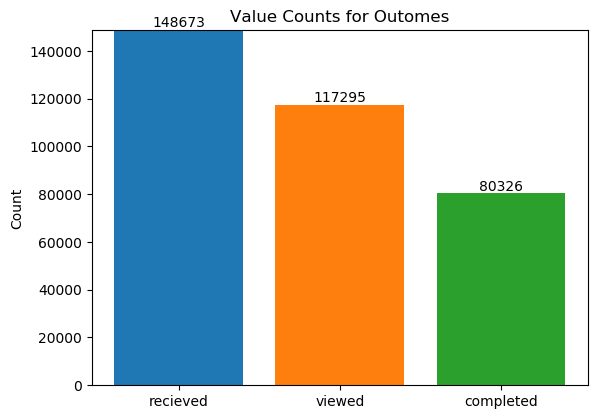

In [218]:
data = {
    'recieved': transaction_with_labels['offer_received'],
    'viewed': transaction_with_labels['offer_viewed'],
    'completed': transaction_with_labels['completed']
}

df = pd.DataFrame(data)


value_counts = df.apply(pd.Series.value_counts)

x_labels = value_counts.columns
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects = ax.bar(x, value_counts.loc[1], color=['#1f77b4', '#ff7f0e', '#2ca02c'])


for i, rect in enumerate(rects):
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 5,
            str(int(value_counts.loc[1][i])),
            ha='center', va='bottom')


ax.set_ylabel('Count')
ax.set_title('Value Counts for Outomes')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, len(df))

plt.subplots_adjust(top=0.85)

plt.show()

# plt.savefig(os.path.join('photos/complete_df_outcomes.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# Which offer was the most successful in terms of the number of completed transactions.

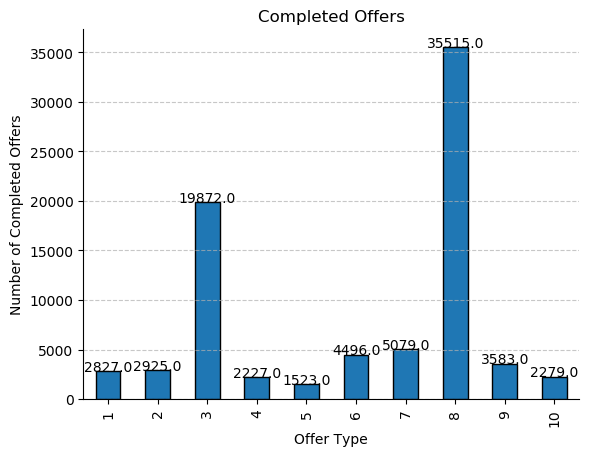

In [222]:
import pandas as pd
import matplotlib.pyplot as plt

# sample data
data = {'Offer': transaction_with_labels['offer'],
        'completed': transaction_with_labels['completed'],
        'Offer Type': transaction_with_labels['offer_type']
       }

# create a pandas DataFrame
df = pd.DataFrame(data)

# count the number of completed offers for each offer type
completed_counts = df.groupby('Offer')['completed'].sum()

ax = completed_counts.plot(kind='bar', edgecolor='black')

# add data labels to the bars
for i, v in enumerate(completed_counts.values):
    ax.text(i, v + 0.6, str(v), ha='center')

# adjust the chart layout and formatting
ax.set_xlabel('Offer Type')
ax.set_ylabel('Number of Completed Offers')
ax.set_title('Completed Offers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# plt.savefig(os.path.join('photos/completed_offers.png'), dpi=300, format='png', bbox_inches='tight') 


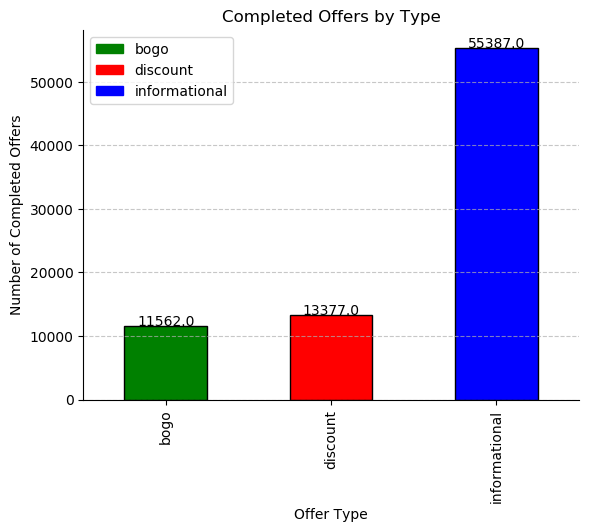

In [224]:
# create sample data
data = {'offer': transaction_with_labels['offer_id'],
        'offer_type': transaction_with_labels['offer_type'],
        'completed': transaction_with_labels['completed']}

# create a pandas DataFrame
df = pd.DataFrame(data)

# count the number of completed offers for each offer type
completed_counts = df.groupby('offer_type')['completed'].sum()

# set colors for each offer type
colors = {'discount': 'red', 'bogo': 'green', 'informational': 'blue'}

# plot the bar chart with different colors for each offer type
ax = completed_counts.plot(kind='bar', color=[colors[i] for i in completed_counts.index], edgecolor='black')

# add data labels to the bars
for i, v in enumerate(completed_counts.values):
    ax.text(i, v + 0.6, str(v), ha='center')

# add a legend that shows the colors of each offer type
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in completed_counts.index]
labels = completed_counts.index
plt.legend(handles, labels)

# adjust the chart layout and formatting
ax.set_xlabel('Offer Type')
ax.set_ylabel('Number of Completed Offers')
ax.set_title('Completed Offers by Type')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# plt.savefig(os.path.join('photos/completed_offers_by_type.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



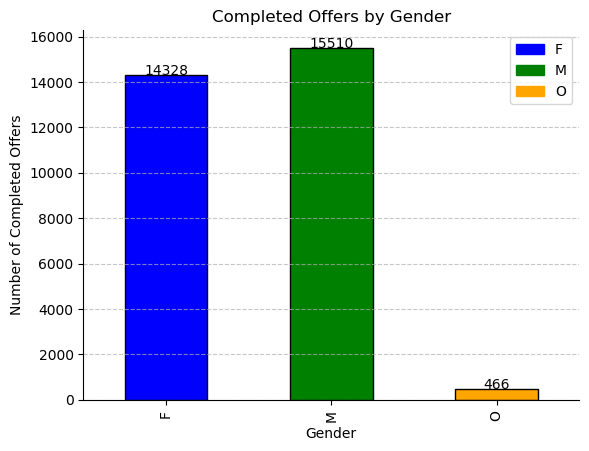

In [226]:
# create sample data
data = {'gender': transaction_with_labels['gender'],
        'completed': transaction_with_labels['offer_completed']}

# create a pandas DataFrame
df = pd.DataFrame(data)

# count the number of completed offers for each offer type
completed_counts = df.groupby('gender')['completed'].sum()

# set colors for each offer type
colors = {'M': 'green', 'F': 'blue', 'O': 'orange'}

# plot the bar chart with different colors for each offer type
ax = completed_counts.plot(kind='bar', color=[colors[i] for i in completed_counts.index], edgecolor='black')

# add data labels to the bars
for i, v in enumerate(completed_counts.values):
    ax.text(i, v + 0.6, str(v), ha='center')

# add a legend that shows the colors of each offer type
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in completed_counts.index]
labels = completed_counts.index
plt.legend(handles, labels)

# adjust the chart layout and formatting
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Completed Offers')
ax.set_title('Completed Offers by Gender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# plt.savefig(os.path.join('photos/completed_offers_by_gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



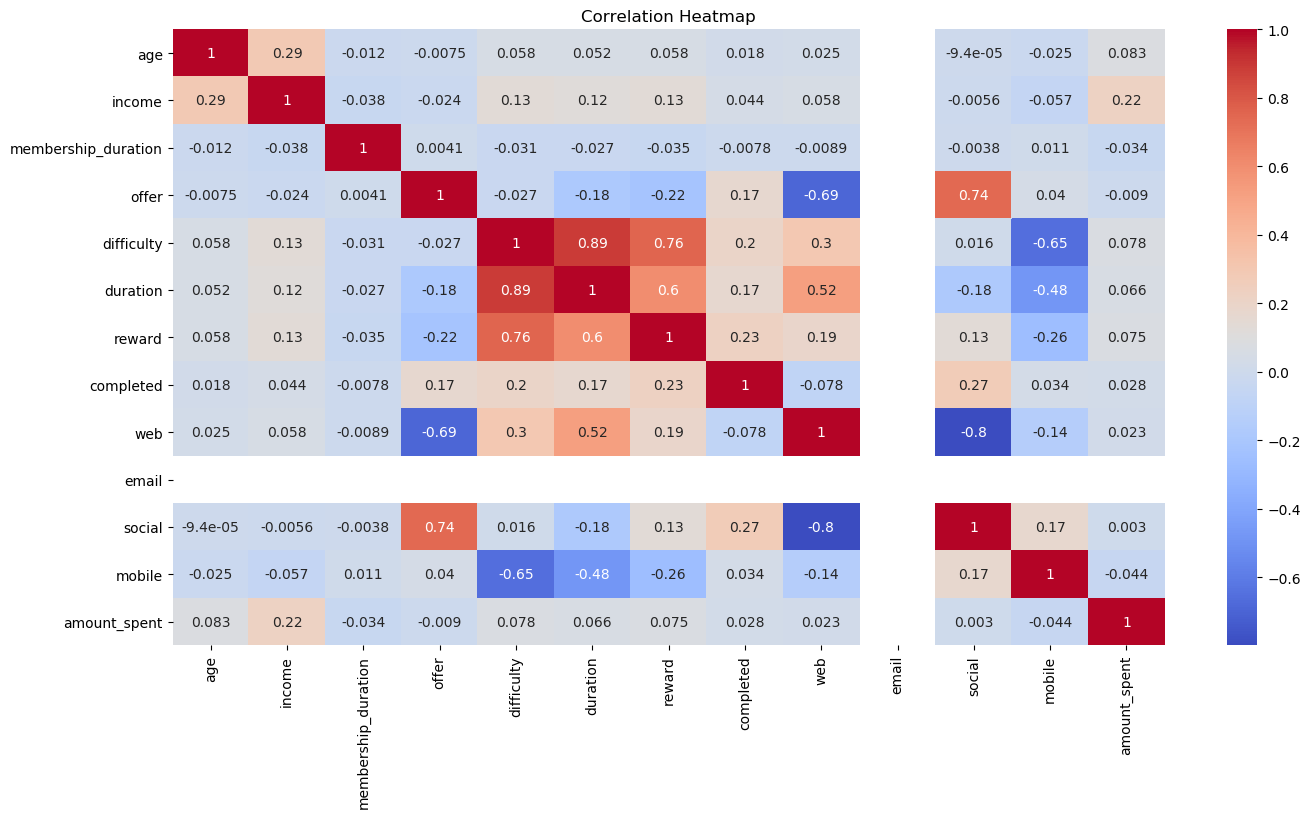

In [236]:
corr = transaction_with_labels[['age', 'income', 'membership_duration', 'offer', 'difficulty', 'duration', 'reward', 'completed', 'web', 'email', 'social', 'mobile', 'amount_spent']].corr()

fig, ax = plt.subplots(figsize=(16, 8))


sns.heatmap(corr, annot = True, cmap='coolwarm')


# for i in range(len(corr.columns)):
#     for j in range(i):
#         if abs(corr.iloc[i, j]) > threshold:
#             text = ax.text(j + 0.5, i + 0.5, "{:.2f}".format(corr.iloc[i, j]),
#                            ha="center", va="center", color="black", fontsize=10)

plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.title('Correlation Heatmap')
plt.show()

# plt.savefig(os.path.join('photos/correlation_heat_map.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


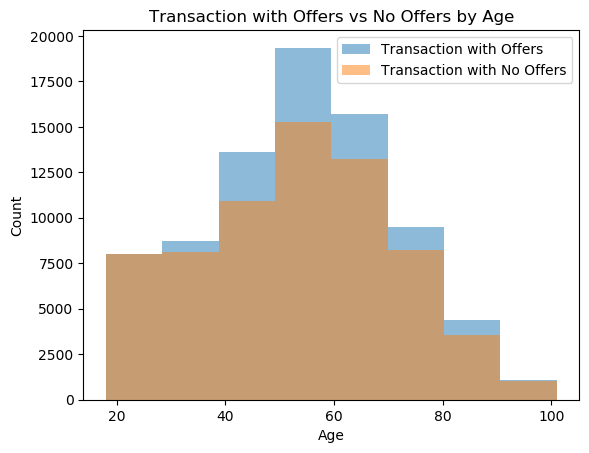

In [244]:
plt.hist(transaction_with_labels['age'][transaction_with_labels['completed'] == 1], bins=8, alpha=0.5, label='Transaction with Offers')
plt.hist(transaction_with_labels['age'][transaction_with_labels['completed'] == 0], bins=8, alpha=0.5, label='Transaction with No Offers')
plt.legend(loc='upper right')

# add labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Transaction with Offers vs No Offers by Age')

plt.show()

# plt.savefig(os.path.join('photos/completed_age.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


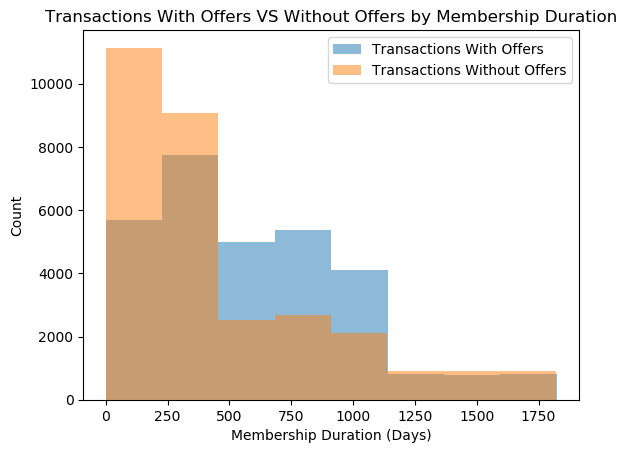

In [245]:
plt.hist(complete_df['membership_duration'][complete_df['offer_completed'] == 1], bins=8, alpha=0.5, label='Transactions With Offers')
plt.hist(complete_df['membership_duration'][complete_df['offer_completed'] == 0], bins=8, alpha=0.5, label='Transactions Without Offers')
plt.legend(loc='upper right')

# add labels and title
plt.xlabel('Membership Duration (Days)')
plt.ylabel('Count')
plt.title('Transactions With Offers VS Without Offers by Membership Duration')

plt.show()

# plt.savefig(os.path.join('photos/completed_membership_duration.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


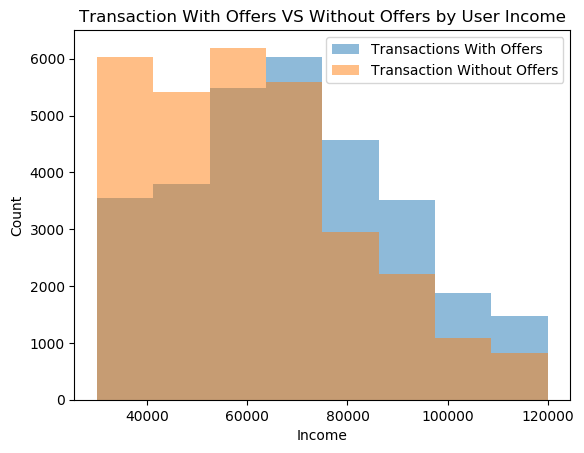

In [247]:
plt.hist(complete_df['income'][complete_df['offer_completed'] == 1], bins=8, alpha=0.5, label='Transactions With Offers')
plt.hist(complete_df['income'][complete_df['offer_completed'] == 0], bins=8, alpha=0.5, label='Transaction Without Offers')
plt.legend(loc='upper right')

# add labels and title
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Transaction With Offers VS Without Offers by User Income')

plt.show()

# plt.savefig(os.path.join('photos/completed_income.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


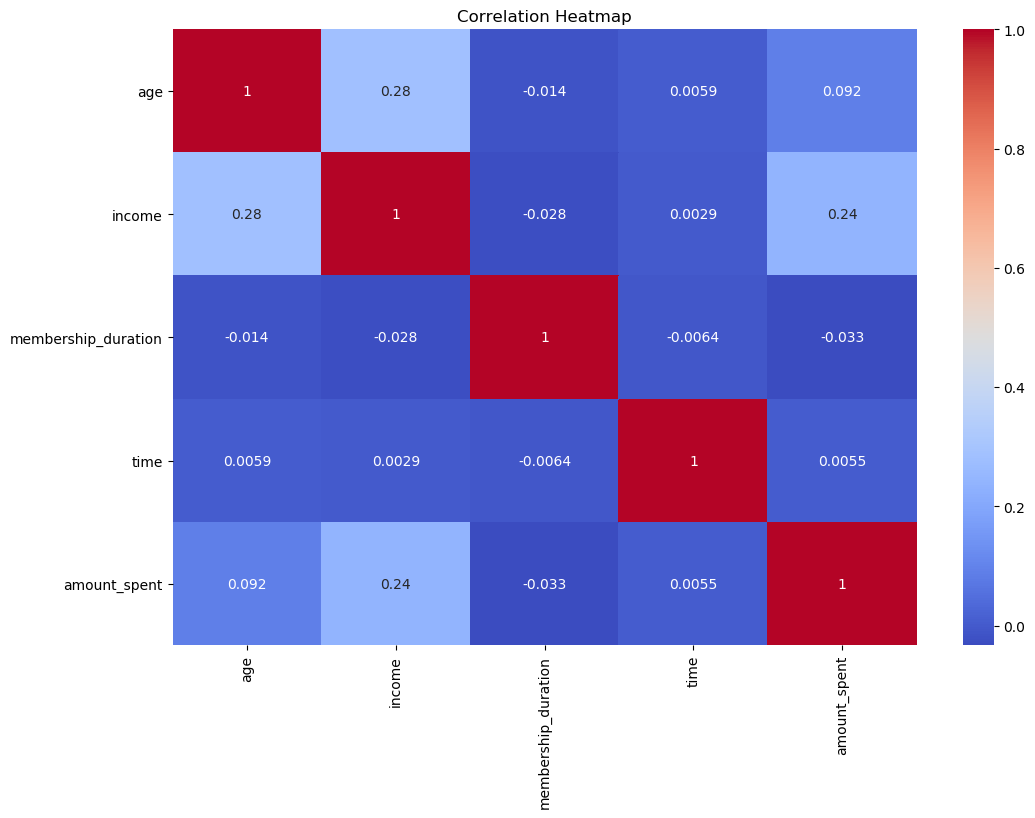

In [188]:
corr = transaction.corr()

fig, ax = plt.subplots(figsize=(12, 8))

threshold = 0.7

sns.heatmap(corr, cmap='coolwarm', annot = True)


for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            text = ax.text(j + 0.5, i + 0.5, "{:.2f}".format(corr.iloc[i, j]),
                           ha="center", va="center", color="black", fontsize=10)

plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.title('Correlation Heatmap')
plt.show()

# plt.savefig(os.path.join('photos/correlation_heat_map.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


In [250]:
transaction_offers.head()

,age,gender,income,became_member_on,membership_duration,person,event,time,amount_spent,offer_received,...,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff,valid_complete
0,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,18,21.51,1,...,1,1,0,1,96,-504.0,0.0,-504.0,600.0,0
1,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,144,32.28,1,...,1,1,0,1,96,-504.0,0.0,-504.0,600.0,0
2,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,528,23.22,1,...,1,1,0,1,168,-408.0,528.0,120.0,48.0,0
3,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,528,23.22,1,...,1,1,0,1,96,-504.0,0.0,-504.0,600.0,0
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,1,...,1,1,0,1,168,6.0,126.0,132.0,36.0,1


In [251]:
# Transactions with no offer

In [252]:
view_offer_before_receiving = transaction_offers[transaction_offers.time < transaction_offers.time_received]

In [253]:
view_offer_before_receiving['valid_complete'].value_counts()

0    49707
Name: valid_complete, dtype: int64

In [254]:
# Completed Transactions With BOGO

In [255]:
transaction_viewed_complete_bogo_offer = transaction_offers[(transaction_offers.offer_type == 'bogo') & (transaction_offers.time == transaction_offers.time_completed) & (transaction_offers.valid_complete == 1)]

In [256]:
transaction_viewed_complete_bogo_offer

,age,gender,income,became_member_on,membership_duration,person,event,time,amount_spent,offer_received,...,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff,valid_complete
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,1,...,1,1,0,1,168,6.0,126.0,132.0,36.0,1
11,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,510,21.72,1,...,0,1,1,1,168,0.0,102.0,102.0,66.0,1
16,68,M,70000.0,2018-04-26,91,e2127556f4f64592b11af22de27a7932,transaction,522,18.42,1,...,1,1,0,1,168,12.0,102.0,114.0,54.0,1
18,65,M,53000.0,2018-02-09,167,389bc3fa690240e798340f5a15918d5c,transaction,60,9.54,1,...,1,1,1,1,120,0.0,60.0,60.0,60.0,1
19,65,M,53000.0,2018-02-09,167,389bc3fa690240e798340f5a15918d5c,transaction,498,15.63,1,...,1,1,0,1,168,30.0,60.0,90.0,78.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148555,75,F,78000.0,2016-07-16,740,392d23b2c958493197f647bedfe4f418,transaction,222,25.24,1,...,0,1,1,1,168,18.0,36.0,54.0,114.0,1
148575,59,F,63000.0,2017-07-31,360,bf3069b178fe40d789dd027901bc406b,transaction,552,13.31,1,...,1,1,0,1,168,6.0,42.0,48.0,120.0,1
148581,57,M,40000.0,2016-07-09,747,76ddbd6576844afe811f1a3c0fbb5bec,transaction,168,112.60,1,...,1,1,0,1,168,60.0,108.0,168.0,0.0,1
148590,64,M,51000.0,2018-01-04,203,f653cf2d8bba42d0a53c2937ee2e5893,transaction,108,5.79,1,...,1,1,1,1,120,12.0,96.0,108.0,12.0,1


In [257]:
# completed transactions with discount

In [258]:
transaction_viewed_complete_discount_offer = transaction_offers[(transaction_offers.offer_type == 'discount') & (transaction_offers.time == transaction_offers.time_completed) & (transaction_offers.valid_complete == 1)]

In [259]:
# completed transactions after viewing informational offer

In [260]:
transaction_from_informational = transaction_offers[(transaction_offers.offer_type == 'informational') & (transaction_offers.amount_spent > 0) & (transaction_offers.time >= transaction_offers.time_received) & (transaction_offers.offer_viewed == 1) ]

In [261]:
transaction_from_informational

,age,gender,income,became_member_on,membership_duration,person,event,time,amount_spent,offer_received,...,web,email,social,mobile,duration_hr,received_viewed,viewed_completed,received_completed_diff,duration_diff,valid_complete
7,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,1,...,0,1,1,1,72,48.0,-216.0,-168.0,240.0,0
8,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,1,...,0,1,1,1,72,48.0,-216.0,-168.0,240.0,0
9,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,1,...,0,1,1,1,72,48.0,-216.0,-168.0,240.0,0
10,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,510,21.72,1,...,0,1,1,1,72,48.0,-216.0,-168.0,240.0,0
12,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,534,26.56,1,...,0,1,1,1,72,48.0,-216.0,-168.0,240.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148650,49,M,73000.0,2017-01-26,546,01d26f638c274aa0b965d24cefe3183f,transaction,396,5.93,1,...,0,1,1,1,72,60.0,-396.0,-336.0,408.0,0
148652,49,M,73000.0,2017-01-26,546,01d26f638c274aa0b965d24cefe3183f,transaction,402,1.74,1,...,0,1,1,1,72,60.0,-396.0,-336.0,408.0,0
148654,49,M,73000.0,2017-01-26,546,01d26f638c274aa0b965d24cefe3183f,transaction,480,2.16,1,...,0,1,1,1,72,60.0,-396.0,-336.0,408.0,0
148656,49,M,73000.0,2017-01-26,546,01d26f638c274aa0b965d24cefe3183f,transaction,576,6.61,1,...,0,1,1,1,72,60.0,-396.0,-336.0,408.0,0


In [262]:
# completed transactions without viewing the offer

In [263]:
transaction_without_view = transaction_offers[(transaction_offers.offer_type != 'informational') & (transaction_offers.valid_complete == 0) & (transaction_offers.offer_completed == 1) &(transaction_offers.time >= transaction_offers.time_received)]

In [264]:
transaction_offers.loc[(transaction_offers.offer_type == 'bogo') & (transaction_offers.time == transaction_offers.time_completed) & (transaction_offers.valid_complete == 1), 'completed'] = 1
transaction_offers.loc[(transaction_offers.offer_type == 'discount') & (transaction_offers.time == transaction_offers.time_completed) & (transaction_offers.valid_complete == 1), 'completed'] = 1
transaction_offers.loc[(transaction_offers.offer_type == 'informational') & (transaction_offers.amount_spent > 0) & (transaction_offers.time >= transaction_offers.time_received) & (transaction_offers.offer_viewed == 1), 'completed'] = 1

In [265]:
transaction_offers.loc[(transaction_offers.time < transaction_offers.time_received), 'label'] = 'buy without offer'
transaction_offers.loc[(transaction_offers.offer_type != 'informational') & (transaction_offers.offer_viewed == 0) & (transaction_offers.offer_completed == 1) & (transaction_offers.time >= transaction_offers.time_received), 'label'] = 'buy without offer'
transaction_offers.loc[(transaction_offers.offer_type == 'informational') & (transaction_offers.offer_viewed == 0) & (transaction_offers.amount_spent > 0), 'label'] = 'buy without offer'
transaction_offers.loc[(transaction_offers.offer_type == 'bogo') & (transaction_offers.time == transaction_offers.time_completed) & (transaction_offers.valid_complete == 1), 'label'] = 'bogo buyers'
transaction_offers.loc[(transaction_offers.offer_type == 'discount') & (transaction_offers.time == transaction_offers.time_completed) & (transaction_offers.valid_complete == 1), 'label'] = 'discount buyers'
transaction_offers.loc[(transaction_offers.offer_type == 'informational') & (transaction_offers.amount_spent > 0) & (transaction_offers.time >= transaction_offers.time_received) & (transaction_offers.offer_viewed == 1), 'label'] = 'informational buyers'

In [266]:
transaction_offers['completed'] = transaction_offers['completed'].fillna(0)

In [267]:
transaction_offers[(transaction_offers.offer_viewed == 0) & (transaction_offers.completed == 1)][['offer_viewed', 'offer_completed', 'amount_spent', 'completed']]

,offer_viewed,offer_completed,amount_spent,completed


In [268]:
transaction_offers[['person', 'offer_type', 'offer_received', 'offer_viewed', 'offer_completed', 'time', 'time_viewed', 'time_received', 'time_completed', 'valid_complete', 'label', 'amount_spent', 'completed']]

,person,offer_type,offer_received,offer_viewed,offer_completed,time,time_viewed,time_received,time_completed,valid_complete,label,amount_spent,completed
0,0610b486422d4921ae7d2bf64640c50b,informational,1,0,0,18,0.0,504,0.0,0,buy without offer,21.51,0.0
1,0610b486422d4921ae7d2bf64640c50b,informational,1,0,0,144,0.0,504,0.0,0,buy without offer,32.28,0.0
2,0610b486422d4921ae7d2bf64640c50b,bogo,1,0,1,528,0.0,408,528.0,0,buy without offer,23.22,0.0
3,0610b486422d4921ae7d2bf64640c50b,informational,1,0,0,528,0.0,504,0.0,0,buy without offer,23.22,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,bogo,1,1,1,132,6.0,0,132.0,1,bogo buyers,19.89,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148668,e4052622e5ba45a8b96b59aba68cf068,informational,1,0,0,480,0.0,576,0.0,0,buy without offer,30.57,0.0
148669,e4052622e5ba45a8b96b59aba68cf068,informational,1,0,0,486,0.0,336,0.0,0,buy without offer,19.47,0.0
148670,e4052622e5ba45a8b96b59aba68cf068,informational,1,0,0,486,0.0,576,0.0,0,buy without offer,19.47,0.0
148671,e4052622e5ba45a8b96b59aba68cf068,informational,1,0,0,690,0.0,336,0.0,0,buy without offer,24.71,0.0


In [269]:
transaction_offers[transaction_offers.label.isna()][['offer_type', 'offer_viewed', 'offer_completed', 'label', 'valid_complete', 'completed', 'amount_spent']]

,offer_type,offer_viewed,offer_completed,label,valid_complete,completed,amount_spent


In [270]:
# transaction_offers.to_csv('data/transaction_with_labels.csv', index = False)

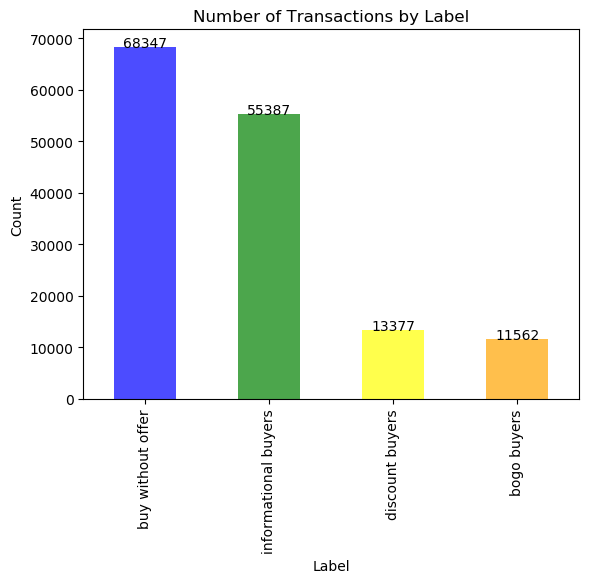

In [286]:
# Create a bar chart with different colors for each value
ax = transaction_with_labels.label.value_counts().plot(kind='bar', color=['blue', 'green', 'yellow', 'orange'], alpha=0.7)

# Add annotations to the bars
for i, v in enumerate(transaction_with_labels.label.value_counts()):
    ax.annotate(str(v), xy=(i, v + 0.2), ha='center')

# Add a title and axis labels
ax.set_title('Number of Transactions by Label')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

# Show the plot
plt.show()

# plt.savefig(os.path.join('photos/user_type.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


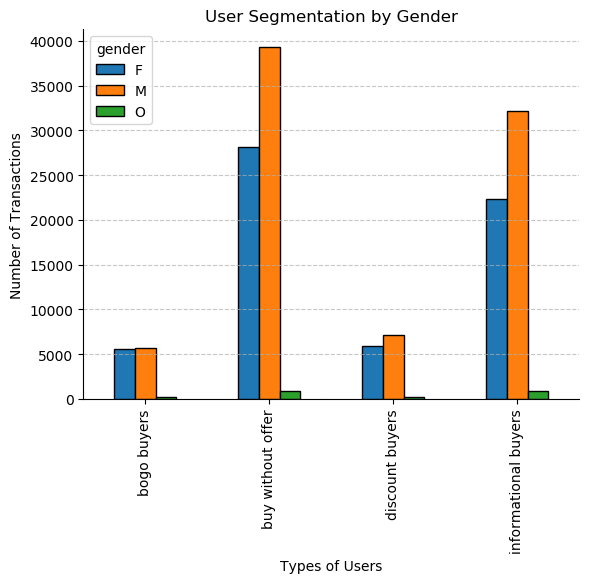

In [287]:
# create a crosstab table of counts by user type and gender
user_gender_counts = pd.crosstab(transaction_with_labels['label'], transaction_with_labels['gender'])

# plot the bar chart with different colors for each gender
ax = user_gender_counts.plot(kind='bar', stacked=False, edgecolor='black')

# adjust the chart layout and formatting
ax.set_xlabel('Types of Users')
ax.set_ylabel('Number of Transactions')
ax.set_title('User Segmentation by Gender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# plt.savefig(os.path.join('photos/user_by_gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



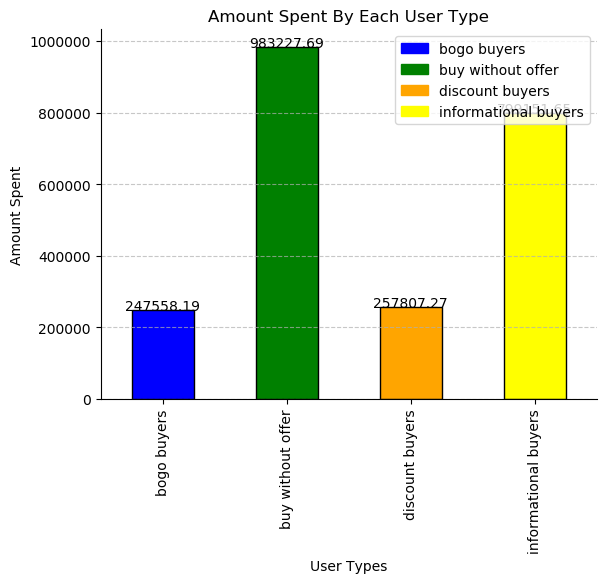

In [288]:
# create sample data
data = {'user type': transaction_with_labels['label'],
        'amount': transaction_with_labels['amount_spent']}

# create a pandas DataFrame
df = pd.DataFrame(data)

# count the number of completed offers for each offer type
amt_sum = df.groupby('user type')['amount'].sum()

# set colors for each offer type
colors = {'buy without offer': 'green', 'bogo buyers': 'blue', 'discount buyers': 'orange', 'informational buyers': 'yellow'}

# plot the bar chart with different colors for each offer type
ax = amt_sum.plot(kind='bar', color=[colors[i] for i in amt_sum.index], edgecolor='black')

# add data labels to the bars
for i, v in enumerate(amt_sum.values):
    ax.text(i, v + 0.6, str(v), ha='center')

# add a legend that shows the colors of each offer type
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in amt_sum.index]
labels = amt_sum.index
plt.legend(handles, labels)

# adjust the chart layout and formatting
ax.set_xlabel('User Types')
ax.set_ylabel('Amount Spent')
ax.set_title('Amount Spent By Each User Type')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# plt.savefig(os.path.join('photos/amount_spent.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
